In [1]:
from __future__ import print_function, unicode_literals, with_statement, absolute_import, generators, nested_scopes, division
import os
import subprocess
from pyspark.sql import SparkSession

runLocal = True

if runLocal:
    spark  = SparkSession.builder.master('local').appName('SOU').getOrCreate()
else:
    p = subprocess.Popen(['sinteractive', '--partition=broadwl', '--cpus-per-task=10', '--time=00:30:00'], stdout=subprocess.PIPE, shell = True)
    print(p.stdout.read())
    # start spark master program on this machine and register worker nodes
    os.system('start-spark-slurm.sh&') # use & to put it into background
    # get ip address of this machine
    ip = os.popen('hostname -i').read().strip('\n')
    # change 'local' to be ip of master node
    spark = SparkSession.builder \
        .master('spark://' + ip + ':7077') \
        .appName('Spark Try') \
        .getOrCreate()
    print('Spark Session web UI: http://{}:4040'.format(ip))

In [2]:
import re
import matplotlib.pyplot as plt
import seaborn
import pyspark.sql.functions
import functools
import numpy as np
import seaborn
%matplotlib inline

In [3]:
df = spark.read.json('/project/cmsc25025/sou/speeches.json')

# Part a

In [68]:
titles = [
    'Mr',
    'Ms',
    'Gen',
]
#Negative look ahead for titles doesn't worh that well
sentRegex = re.compile(r'\.\s+(?=[A-Z])')

@pyspark.sql.functions.udf
def sentenceSplit(s):
    return [sent.strip() for sent in re.split(sentRegex, s)]

sentencesDF = df.withColumn('sentences', sentenceSplit(df.text)).withColumn('year_int', df.year.cast('int'))
sentencesDF.show(5)

+--------------------+--------------------+----+--------------------+--------+
|           president|                text|year|           sentences|year_int|
+--------------------+--------------------+----+--------------------+--------+
|        James Monroe| Fellow-Citizens ...|1821|[Fellow-Citizens ...|    1821|
|    William McKinley| To the Senate an...|1897|[To the Senate an...|    1897|
|Dwight D. Eisenhower|[Delivered in per...|1960|[[Delivered in pe...|    1960|
|     Calvin Coolidge|Since the close o...|1923|[Since the close ...|    1923|
|       James Madison| Fellow-Citizens ...|1816|[Fellow-Citizens ...|    1816|
+--------------------+--------------------+----+--------------------+--------+
only showing top 5 rows



Sentences have been found and are in the `sentences` column of the dataframe

# Part b

In [70]:
wordRegex = re.compile(r'\s+')

@pyspark.sql.functions.udf
def wordsplit(sents):
    return [re.split(wordRegex, sent) for sent in sents]

@pyspark.sql.functions.udf
def sentLengths(splitSents):
    return [len(sent) for sent in splitSents]

@pyspark.sql.functions.udf
def countSents(sents):
    return len(sents)

@pyspark.sql.functions.udf
def avgNumWords(numSents):
    l = len(numSents)
    return sum(numSents) / l

@pyspark.sql.functions.udf
def totWords(numWords):
    return sum(numWords)

@pyspark.sql.functions.udf
def longestSentComb(splitSents):
    s = sorted(splitSents, key = lambda x: len(x))
    return [len(s[-1]), ' '.join(s[-1])]

@pyspark.sql.functions.udf
def shortestSentComb(splitSents):
    s = sorted(splitSents, key = lambda x: len(x))
    return [len(s[0]), ' '.join(s[0])]

@pyspark.sql.functions.udf
def getFirst(l):
    return l[0]

@pyspark.sql.functions.udf
def getSecond(l):
    return l[1]

wordDF = sentencesDF.withColumn('words', wordsplit(sentencesDF.sentences))
wordDF = wordDF.withColumn('num_words', sentLengths(wordDF.words))
wordDF = wordDF.withColumn('num_sents', countSents(wordDF.sentences))
wordDF = wordDF.withColumn('avgNum_words', avgNumWords(wordDF.num_words))
wordDF = wordDF.withColumn('total_words', totWords(wordDF.num_words).cast('int'))

wordDF = wordDF.withColumn('longest_sentence_combined', longestSentComb(wordDF.words))
wordDF = wordDF.withColumn('longest_len', getFirst(wordDF.longest_sentence_combined))
wordDF = wordDF.withColumn('longest_sentence', getSecond(wordDF.longest_sentence_combined))

wordDF = wordDF.withColumn('shortest_sentence_combined', shortestSentComb(wordDF.words))
wordDF = wordDF.withColumn('shortest_len', getFirst(wordDF.shortest_sentence_combined))
wordDF = wordDF.withColumn('shortest_sentence', getSecond(wordDF.shortest_sentence_combined))


perYear = wordDF.orderBy(wordDF.year_int.asc()).groupby('year_int').agg({'avgNum_words' : 'mean', 'num_sents' : 'mean'})

In [ ]:
def regression(x, y):
    Y = np.matrix(y).T
    X = np.matrix(np.stack([np.ones((len(x), )), x], axis = 1))
    B = np.linalg.inv(X.T * X) * X.T * Y
    return np.array(B)

perYearDF = perYear.toPandas()

wordsParams = regression(perYearDF['year_int'], perYearDF['avg(avgNum_words)'])

sentsParams = regression(perYearDF['year_int'], perYearDF['avg(num_sents)'])

perYearDF['wordsOLS'] = perYearDF['year_int']* wordsParams[1] + wordsParams[0] 
perYearDF['sentsOLS'] = perYearDF['year_int']* sentsParams[1] + sentsParams[0]

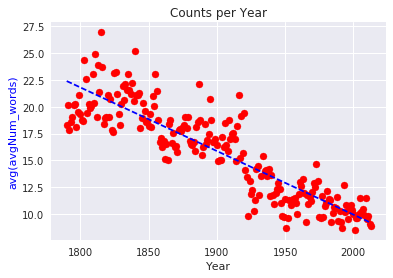

[[  1.28468306e+02]
 [ -5.92617919e-02]]


In [17]:
fig, ax = plt.subplots()

ax.scatter(perYearDF['year_int'], perYearDF['avg(avgNum_words)'], color = 'r')
ax.plot(perYearDF['year_int'], perYearDF['wordsOLS'], '--', color = 'b')
ax.set_ylabel('avg(avgNum_words)', color='b')

ax.set_xlabel('Year')
ax.set_title("Counts per Year")
plt.show()
print(wordsParams)

We have the per year average number of words, which shows a downward trend of about 1.1 words every 10 years. 

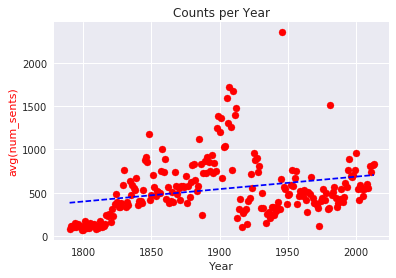

[[ -2.18040434e+03]
 [  1.43378978e+00]]


In [18]:
fig, ax2 = plt.subplots()

ax2.scatter(perYearDF['year_int'], perYearDF['avg(num_sents)'], color = 'r')
ax2.plot(perYearDF['year_int'], perYearDF['sentsOLS'], '--', color = 'b')
ax2.set_ylabel('avg(num_sents)', color='r')

ax2.set_xlabel('Year')
ax2.set_title("Counts per Year")
plt.show()
print(sentsParams)

We have the per year average number of sentences, which shows a upward trend of about 7 sentences every 10 years. These two trends show the speeches are trending to towards more, shorter sentences. This could indicate a lowering of attention span for the audience.

# Part c

In [19]:
earlyDF = wordDF.filter(wordDF.year_int < 1913).select('year_int', 'total_words').toPandas()
lateDF = wordDF.filter(wordDF.year_int > 1912).select('year_int', 'total_words').toPandas()

earlyParams = regression(earlyDF['year_int'], earlyDF['total_words'])

lateParams = regression(lateDF['year_int'], lateDF['total_words'])

earlyDF['totOLS'] = earlyDF['year_int']* earlyParams[1] + earlyParams[0] 
lateDF['totOLS'] = lateDF['year_int']* lateParams[1] + lateParams[0]

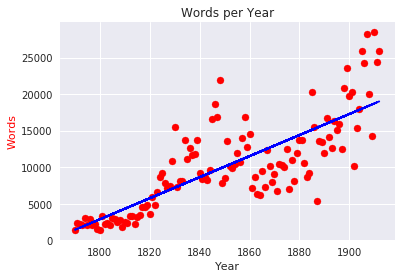

[[ -2.18040434e+03]
 [  1.43378978e+00]]


In [20]:
fig, ax = plt.subplots()

ax.scatter(earlyDF['year_int'], earlyDF['total_words'], color = 'r')
ax.plot(earlyDF['year_int'], earlyDF['totOLS'], '--', color = 'b')
ax.set_ylabel('Words', color='r')

ax.set_xlabel('Year')
ax.set_title("Words per Year")
plt.show()
print(sentsParams)

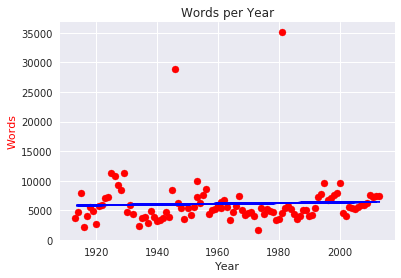

[[ -2.18040434e+03]
 [  1.43378978e+00]]


In [21]:
fig, ax = plt.subplots()

ax.scatter(lateDF['year_int'], lateDF['total_words'], color = 'r')
ax.plot(lateDF['year_int'], lateDF['totOLS'], '--', color = 'b')
ax.set_ylabel('Words', color='r')

ax.set_xlabel('Year')
ax.set_title("Words per Year")
plt.show()
print(sentsParams)

1913 marked is when the SOU started being addressed directly to the US congress. Thus there is a much harder time limit and thus most addresses have the same temporal length, which have thus have similar word counts, unlike before.

# Part d

In [22]:
presDF = wordDF.groupby('president').agg({'avgNum_words' : 'mean'}).toPandas()

In [23]:
sortedDF = presDF.sort_values(by = 'avg(avgNum_words)')
n = len(sortedDF)
print("min: {} at {:.2f}".format(*sortedDF.iloc[0]))
print("25%: {:.2f}".format((sortedDF.iloc[n // 4][1] + sortedDF.iloc[n // 4 + 1][1]) / 2))
print("50%: {:.2f}".format((sortedDF.iloc[n // 2][1] + sortedDF.iloc[n // 2 + 1][1]) / 2))
print("75%: {:.2f}".format((sortedDF.iloc[n // 4 * 3][1] + sortedDF.iloc[n // 4 * 3 + 1][1]) / 2))
print("max: {} at {:.2f}".format(*sortedDF.iloc[-1]))

min: George Bush at 9.39
25%: 12.23
50%: 16.95
75%: 19.15
max: James Madison at 22.91


Above are shown all the requested statistics

In [76]:
wordDF.orderBy(wordDF.shortest_len.asc()).select('shortest_len', 'shortest_sentence').show(10)

+------------+-----------------+
|shortest_len|shortest_sentence|
+------------+-----------------+
|           1|       EISENHOWER|
|           1|               Mr|
|           1|           Second|
|           1|            Marys|
|           1|       EISENHOWER|
|           1|               Mr|
|           1|            Louis|
|           1|             Hull|
|           1|               Mr|
|           1|               Mr|
+------------+-----------------+
only showing top 10 rows



The shortested sentences are shown above, you can see that the tokenizer has problems with prefixs, such as `'MR'`.

In [78]:
wordDF.orderBy(wordDF.longest_len.desc()).select('longest_len', 'longest_sentence').show(3, truncate = False)

+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|longest_len|longest_sentence                                                                                                                                                                                                                                                                                                                                                                      

The longest sentences are shown above there are three at 99 words so I am showing the first 3.